P911.DE: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.65
Annualised Volatility: 0.43


            AAPL  AVGO   NVDA  RACE  SALM
allocation  20.5   2.6  69.28  6.33  1.28
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.27


             AAPL  AVGO  NVDA   RACE  SALM
allocation  27.91  10.8  2.21  55.27  3.81


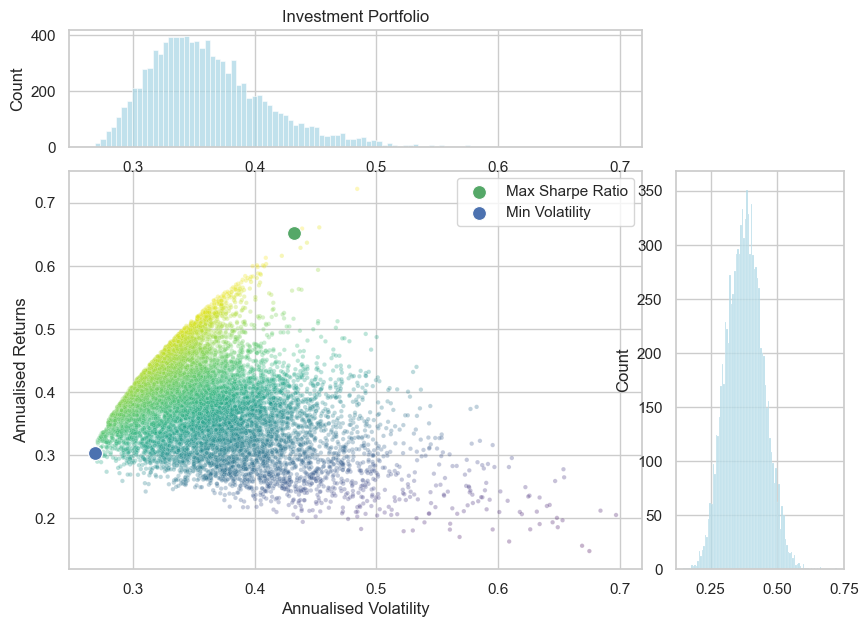

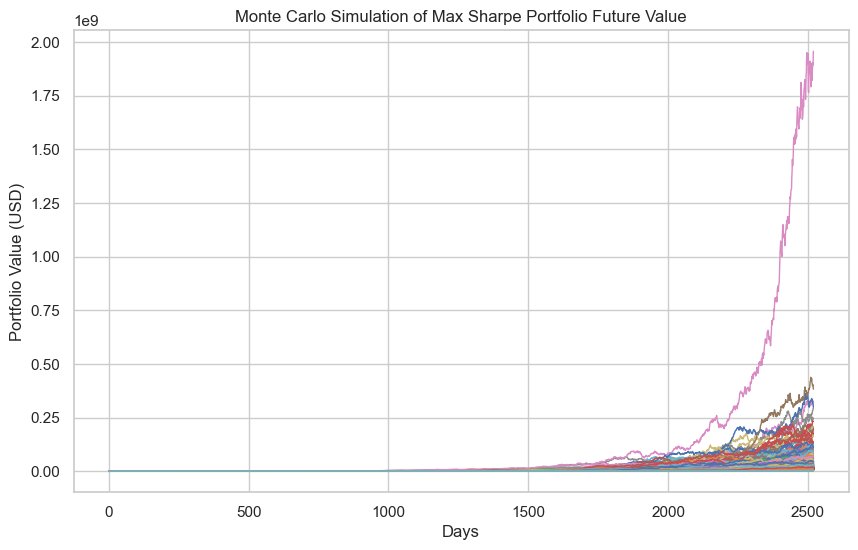

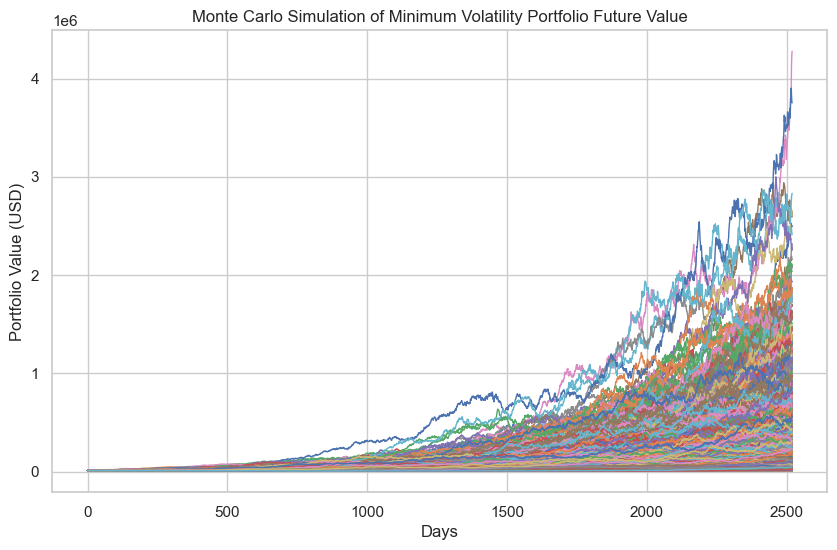

Max Sharpe Portfolio - Value at Risk (VaR): 0.0017683087781726642
Max Sharpe Portfolio - Conditional Value at Risk (CVaR): 0.0016566172601277568
Minimum Volatility Portfolio - Value at Risk (VaR): 0.00078370959328264
Minimum Volatility Portfolio - Conditional Value at Risk (CVaR): 0.000716623229737616


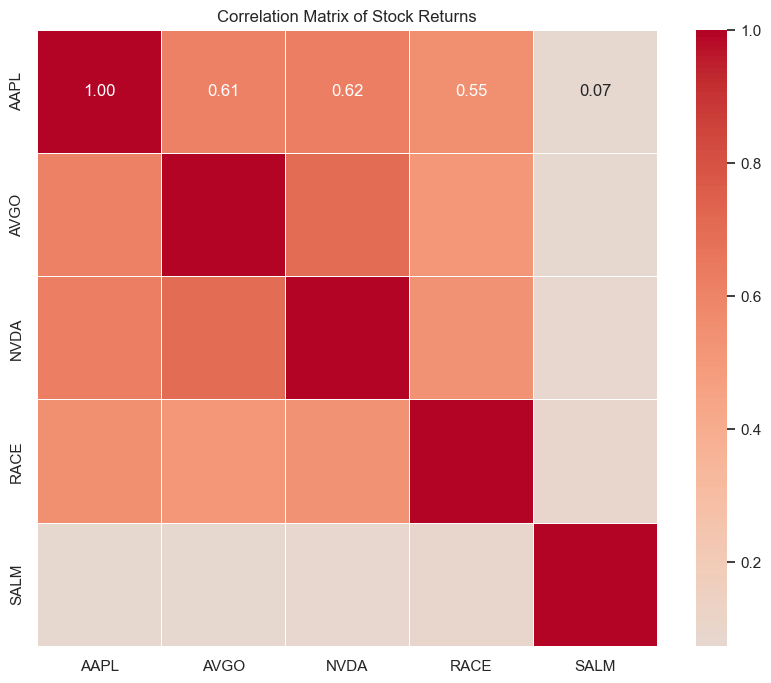

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco
from matplotlib.gridspec import GridSpec

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plot configuration
plt.style.use('grayscale')
np.random.seed(123)
sns.set_theme(style="whitegrid")

# Ticker input
tickers = ['AAPL', 'AVGO', 'NVDA', 'PSNY', 'ORSTED.CO', 'NOVO-B.CO', 'BO.CO', 'RACE', 'RHM.DE', 'SAAB-B.ST', 'TKA.DE', 'P911.DE', 'PLTR', 'RIVN', 'MOWI.OL', 'SALM', 'SALME.OL']

# Fetch historical price data
def fetch_historical_data(tickers):
    data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="5y")
        data[ticker] = hist['Close']
    return data

# Data
data = fetch_historical_data(tickers)

# Cleaning missing values
data.dropna(axis=1, inplace=True)

# Convert daily closing prices to returns
returns = data.pct_change()

# Portfolio optimization code
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    with pd.option_context('mode.use_inf_as_na', True):
        results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
        
        max_sharpe_idx = np.argmax(results[2])
        sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
        max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=data.columns, columns=['allocation'])
        max_sharpe_allocation.allocation = [round(i*100, 2) for i in max_sharpe_allocation.allocation]
        max_sharpe_allocation = max_sharpe_allocation.T
        
        min_vol_idx = np.argmin(results[0])
        sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]
        min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index=data.columns, columns=['allocation'])
        min_vol_allocation.allocation = [round(i*100, 2) for i in min_vol_allocation.allocation]
        min_vol_allocation = min_vol_allocation.T
        
        print("-" * 80)
        print("Maximum Sharpe Ratio Portfolio Allocation\n")
        print("Annualised Return:", round(rp, 2))
        print("Annualised Volatility:", round(sdp, 2))
        print("\n")
        print(max_sharpe_allocation)
        print("-" * 80)
        print("Minimum Volatility Portfolio Allocation\n")
        print("Annualised Return:", round(rp_min, 2))
        print("Annualised Volatility:", round(sdp_min, 2))
        print("\n")
        print(min_vol_allocation)
        
        fig = plt.figure(figsize=(10, 7))
        gs = GridSpec(4, 4)
        
        ax_scatter = fig.add_subplot(gs[1:4, 0:3])
        sns.scatterplot(x=results[0, :], y=results[1, :], hue=results[2, :], palette='viridis', legend=None, s=10, alpha=0.3, ax=ax_scatter)
        sns.scatterplot(x=[sdp], y=[rp], marker='o', color='g', s=100, label='Max Sharpe Ratio', ax=ax_scatter)
        sns.scatterplot(x=[sdp_min], y=[rp_min], marker='o', color='b', s=100, label='Min Volatility', ax=ax_scatter)
        ax_scatter.set_xlabel('Annualised Volatility')
        ax_scatter.set_ylabel('Annualised Returns')
        ax_scatter.legend()
        
        ax_hist_y = fig.add_subplot(gs[0, 0:3])
        sns.histplot(results[0, :], bins=100, color='lightblue', ax=ax_hist_y)
        ax_hist_y.set_title('Investment Portfolio')
        
        ax_hist_x = fig.add_subplot(gs[1:4, 3])
        sns.histplot(results[1, :], bins=100, color='lightblue', orientation='horizontal', ax=ax_hist_x)

        plt.show()
        
        return weights[max_sharpe_idx], weights[min_vol_idx]

# Input parameters
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 10000
risk_free_rate = 0.04  # 4.0% risk-free rate

# Running portfolio analyses
max_sharpe_weights, min_vol_weights = display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Monte Carlo simulation for future values of portfolios
def monte_carlo_simulation(start_prices, mean_returns, cov_matrix, weights, num_simulations, num_days, initial_investment):
    portfolio_start = initial_investment
    result = np.zeros((num_days, num_simulations))
    result[0] = portfolio_start
    for t in range(1, num_days):
        simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)
        result[t] = result[t - 1] * (1 + np.dot(simulated_returns, weights))
    return result

# Run Monte Carlo simulation
num_simulations = 10000
num_days = 252 * 10  # 10 years
initial_investment = 10000  # USD 10,000

# Simulations for Max Sharpe Portfolio
simulations_max_sharpe = monte_carlo_simulation(data.iloc[-1].values, mean_returns, cov_matrix, max_sharpe_weights, num_simulations, num_days, initial_investment)

# Simulations for Minimum Volatility Portfolio
simulations_min_vol = monte_carlo_simulation(data.iloc[-1].values, mean_returns, cov_matrix, min_vol_weights, num_simulations, num_days, initial_investment)

# Plot Monte Carlo Simulation Results for Max Sharpe Portfolio
plt.figure(figsize=(10, 6))
plt.plot(simulations_max_sharpe, lw=1)
plt.title('Monte Carlo Simulation of Max Sharpe Portfolio Future Value')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (USD)')
plt.show()

# Plot Monte Carlo Simulation Results for Minimum Volatility Portfolio
plt.figure(figsize=(10, 6))
plt.plot(simulations_min_vol, lw=1)
plt.title('Monte Carlo Simulation of Minimum Volatility Portfolio Future Value')
plt.xlabel('Days')
plt.ylabel('Portfolio Value (USD)')
plt.show()

# Monte Carlo Simulation for VaR and CVaR
def calculate_var_cvar(portfolio_returns, confidence_level=0.95):
    var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    cvar = portfolio_returns[portfolio_returns <= var].mean()
    return var, cvar

# Calculate daily portfolio returns from simulations
portfolio_returns_max_sharpe = np.diff(np.log(simulations_max_sharpe), axis=0)
portfolio_returns_max_sharpe = portfolio_returns_max_sharpe.mean(axis=1)

portfolio_returns_min_vol = np.diff(np.log(simulations_min_vol), axis=0)
portfolio_returns_min_vol = portfolio_returns_min_vol.mean(axis=1)

# Calculate VaR and CVaR for Max Sharpe Portfolio
var_max_sharpe, cvar_max_sharpe = calculate_var_cvar(portfolio_returns_max_sharpe)

# Calculate VaR and CVaR for Minimum Volatility Portfolio
var_min_vol, cvar_min_vol = calculate_var_cvar(portfolio_returns_min_vol)

print(f"Max Sharpe Portfolio - Value at Risk (VaR): {var_max_sharpe}")
print(f"Max Sharpe Portfolio - Conditional Value at Risk (CVaR): {cvar_max_sharpe}")

print(f"Minimum Volatility Portfolio - Value at Risk (VaR): {var_min_vol}")
print(f"Minimum Volatility Portfolio - Conditional Value at Risk (CVaR): {cvar_min_vol}")

# Correlation analysis
corr = returns.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Stock Returns')
plt.show()